In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

num_epochs = 5
total_series_length = 50000
truncated_backprop_length = 15 # number of steps to backpropagate through time
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
%matplotlib notebook

### Generate Training Data
* Here we are just making random binary vectors.
* Our "label" (i.e. the output) will be an echo of the input, shifted `echo_steps` to the right.
* Notice the reshaping of the data into a matrix with `batch_size` rows.

In [2]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step) # roll by echo_step places to create our "echo" data
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))

    return (x, y)

* On each run, the batch data is fed to placeholders, which are the starting nodes of the computational graph.
* Also the RNN state is supplied in a placeholder, which is saved from the output of the previous run.
* Weights and biases of the network are again tensorflow `Variables` which makes then persistent across runs, and allows them to be updated incrementally for each batch.
* At each run, we slide the "batch window" by `truncated_backprop_length` steps to the right

In [3]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

# Not needed in this new version
# W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
# b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

* We want to split the batch data into adjacent time-steps
* We do this by unstacking the columns (`axis=1`) into a Python list
* This will allow the RNN to simultaneously train on different parts of the time series.
* Note that we are using the convention `VARIABLENAME_series` to emphasize that the variable is a list representing a timeseries with multiple samples at each step.
* Because training is being done simultaneously on `batch_size` different places in our time-series, this requires us to save `batch_size` number of instances of RNN states when propagating forward. 
* You can see that we are accounting for this as the `init_state` placeholder has `batch_size` number of rows.

### Forward Pass
* Notice in the `tf.concat` operation we use to create `input_and_state_concatenated`, what we actually want to do is calculate the sum of two affine transformations:
    * `current_input * Wa` and
    * `current_state * Wb
* By combining these two resulting tensors, this allows us to use only one matrix multiplication. 
* Then the bias `b` is broadcast on all samples in the batch
<img src='../pics/RNN_no_frills_forward_pass.png'>

### Previous Forward Pass

### New Forward Pass
* We are now using TensorFlow's `BasicRNNCell` class
* `tf.contrib.rnn.BasicRNNCell(num_units, activation=None, reuse=None, name=None, dtype=None)`
* `static_rnn` unrolls the RNN and creates the graph automatically, so we can remove the for-loop. The function returns a series of previous states as well as the last state.

In [4]:
# Unstack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

#### Side note: Why do we use `tf.tanh()` as our activation function, and not ReLU?
* RNNs manage an internal state vector whose values should be able to increase or decrease when we add the output of some function. 
* The output from tanh can be positive or negative, allowing for increases and decreases in the state.

### Calculating loss
* This is the final part of the graph: a fully connected softmax layer from the state to the output that will make the classes one-hot encoded. 
* We then calculate the loss of the batch.
* `sparse_softmax_cross_entropy_with_logits` automatically calculates the softmax internaly and then computes the cross-entropy. 
* In this example, our classes are mutually exclusive (they are either `0` or `1`), thus we use **sparse** softmax.
* The logits should be of shape `[batchsize, num_classes]` and the labels of shape `[batch_size]`.

In [5]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

#### Side note: What is `truncated_backprop_length` ???
* When a RNN is trained, it is actually treated as a deep neural network with reoccurring weights in every layer. 
* These layers will not be unrolled to the beginning of time as that would be too computationally expensive.
* Therefore, the layers are truncated at a limited number of time-steps. In the diagram above, the error is backpropagated three steps in our batch.

### Saving

In [6]:
saver = tf.train.Saver()
save_dir = 'RNN_checkpoints'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')

### Visualization

In [7]:
def plot_results(loss_list, predictions_series, batchX, batchY,dynamic=False):
    plt.subplot(2, 3, 1)
    if dynamic:
        plt.gca()
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    if dynamic:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.0001)

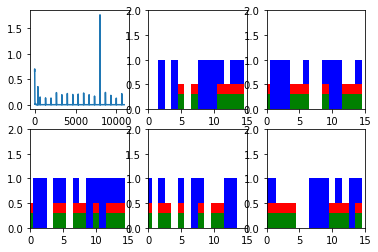

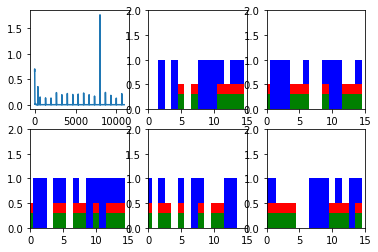

Step 300 Loss 0.00011137446
Step 300 Loss 0.00011137446
Step 300 Loss 0.00011137446


KeyboardInterrupt: 

In [8]:
dynamic_plotting = True

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                if dynamic_plotting:
                    plot_results(loss_list, _predictions_series, batchX, batchY,dynamic=True)
                    print("Step",batch_idx, "Loss", _total_loss)
                else:
                    plot_results(loss_list, _predictions_series, batchX, batchY,dynamic=False)
                    print("Step",batch_idx, "Loss", _total_loss)
                print("Step",batch_idx, "Loss", _total_loss)
                print("Step",batch_idx, "Loss", _total_loss)


plt.ioff()
plt.show()